# Определение вероятности покупки

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

Цель исследования: разработка модели, способной предсказать вероятность покупки в следующие 90 дней.

Задачи исследования:
- Изучение данных
- Разработка новых признаков
- Разработка модели классификации пользователей
- Улучшение модели и повышение метрики roc-auc
- Проведение тестирования модели

# Описание данных

Имеющиеся для обучения данные представлены в пяти файлах:

<div>
<b>apparel-purchases</b> - история покупок

<br>Признаки:
<br><b>1. client_id</b> - идентификатор пользователя
<br><b>2. quantity</b> - количество товаров в заказе
<br><b>3. price</b> - цена товара
<br><b>4. category_ids</b> - вложенные категории, к которым относится товар
<br><b>5. date</b> - дата покупки
<br><b>6. message_id</b> - id сообщения из рассылки
</div>

<div>
<b>apparel-messages</b> - история рекламных рассылок

<br>Признаки:
<br><b>1. bulk_compaign_id</b> - идентификатор рекоамной компании
<br><b>2. client_id</b> - идентификатор пользователя
<br><b>3. message_id</b> - идентификатор сообщения
<br><b>4. event</b> - тип действия
<br><b>5. channel</b> - канал рассылки
<br><b>6. date</b> - дата рассылки
<br><b>6. created_at</b> - время создания сообщения
</div>

<div>
<b>apparel-target-binary</b> - совершит ли клиент покупку в течение следующих 90 дней

<br>Признаки:
<br><b>1. client_id</b> - идентификатор пользователя
<br><b>2. target</b> - целевой признак
</div>

<div>
<b>full_campaign_daily_event</b> - Агрегация общей базы рассылок по дням и типам событий

<br>Признаки:
<br><b>1. date</b> - дата
<br><b>2. bulk_campaign_id</b> - идентификатор рассылки
<br><b>3. count_event*</b> - общее количество количество каждого события event
<br><b>4. nunique_event*</b> - количество уникальных client_id в каждом событии
</div>

<div>
<b>full_campaign_daily_event_channel</b> - Агрегация по дням с учетом событий и каналов рассылки

<br>Признаки:
<br><b>1. date</b> - дата
<br><b>2. bulk_campaign_id</b> - идентификатор рассылки
<br><b>3. count_event*_channel*</b> - общее количество каждого события по каналам
<br><b>4. nunique_event*_channel*</b> - количество уникальных client_id по событиям и каналам
</div>

## Подготовка данных

### Импорт библиотек

In [12]:
%pip install -q phik
%pip install --upgrade -q scikit-learn==1.2.2
%pip install -q imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
import phik
import shap
import datetime
import json

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import ADASYN
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings('ignore')
sns.set_theme(rc={'figure.figsize':(15, 8)})

### Загрузка данных

In [15]:
purchases = pd.read_csv('datasets/apparel-purchases.csv', parse_dates=['date'])
messages = pd.read_csv('datasets/apparel-messages.csv', parse_dates=['date', 'created_at'])
target = pd.read_csv('datasets/apparel-target_binary.csv')
campaign_daily_event = pd.read_csv('datasets/full_campaign_daily_event.csv', parse_dates=['date'])
campaign_daily_event_channel = pd.read_csv('datasets/full_campaign_daily_event_channel.csv', parse_dates=['date'])

### Проверка загрузки

#### purchases

In [18]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [19]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


Данные загрузились корректно: столбцы читаемы. Типы данных столбца price мы исправим, а значения category_ids преобразуем в дальнейшем для удобства работы. Явных пропусков данных нет

#### messages

In [22]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [23]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


Данные файла messages загружены корректно

#### target

In [26]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [27]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


#### full_campaign_daily_event

In [29]:
campaign_daily_event.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [30]:
campaign_daily_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain     131072 non-null  int64         
 13  nunique_hard_b

Данные загружены корректно, пропусков не наблюдается

#### full_campaign_daily_event_channel

In [33]:
campaign_daily_event_channel.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
campaign_daily_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64         
 10  count_unsubscribe_email          131072 non-

Данные загружены корректно, пропусков не обнаружено

### Изменение типов данных

Изменим тип данных price датасета purchases на целочисленное значение:

In [38]:
purchases.price = purchases.price.astype('int')

### Обработка дубликатов

Проверим, сколько явных дубликатов присутствует в записях:

In [41]:
purchases.duplicated().sum()

73020

Избавляться от дубликатов в датасете о покупках нецелесообразно, поскольку каждое наблюдение - отдельный купленный товар, и независимо от дублирования, он может иметь значение для предсказания покупки

In [43]:
messages.duplicated().sum()

48610

С сообщениями ситуация иная: дубликат сообщения, например, о подписке на товар, вряд ли окажется полезным при прогнозировании. Однако, удалив данные, мы рискуем потерять другие ценные признаки при объединении таблиц. Оценим необходимость удаления таких признаков в дальнейшем.

In [45]:
campaign_daily_event.duplicated().sum()

0

In [46]:
campaign_daily_event_channel.duplicated().sum()

0

В остальных датасетах дубликатов не обнаружено

### Обработка пропусков

Проверим наличие пропусков в данных:

In [50]:
purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [51]:
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [52]:
campaign_daily_event.isna().sum()

date                   0
bulk_campaign_id       0
count_click            0
count_complain         0
count_hard_bounce      0
count_open             0
count_purchase         0
count_send             0
count_soft_bounce      0
count_subscribe        0
count_unsubscribe      0
nunique_click          0
nunique_complain       0
nunique_hard_bounce    0
nunique_open           0
nunique_purchase       0
nunique_send           0
nunique_soft_bounce    0
nunique_subscribe      0
nunique_unsubscribe    0
count_hbq_spam         0
nunique_hbq_spam       0
count_close            0
nunique_close          0
dtype: int64

In [53]:
campaign_daily_event_channel.isna().sum()

date                               0
bulk_campaign_id                   0
count_click_email                  0
count_click_mobile_push            0
count_open_email                   0
count_open_mobile_push             0
count_purchase_email               0
count_purchase_mobile_push         0
count_soft_bounce_email            0
count_subscribe_email              0
count_unsubscribe_email            0
nunique_click_email                0
nunique_click_mobile_push          0
nunique_open_email                 0
nunique_open_mobile_push           0
nunique_purchase_email             0
nunique_purchase_mobile_push       0
nunique_soft_bounce_email          0
nunique_subscribe_email            0
nunique_unsubscribe_email          0
count_hard_bounce_mobile_push      0
count_send_mobile_push             0
nunique_hard_bounce_mobile_push    0
nunique_send_mobile_push           0
count_hard_bounce_email            0
count_hbq_spam_email               0
count_send_email                   0
n

Пропусков не обнаружено

### Вывод по разделу

<div>
В рамках этапа подготовки данных мы загрузили и проверили корректность загрузки датасетов, а также привели типы данных в колонках к оптимальным для дальнейшей работы. Кроме того, мы обработали дубликаты в данных и проверили их на наличие пропусков.
</div>

## Конструирование признаков

Объединим данные в один датафрейм, но прежде сохраним для сравнения число уникальных client_id выборки:

In [59]:
rows_before = len(purchases.client_id.unique())

In [60]:
data = pd.merge(purchases, messages, on=['client_id', 'message_id', 'date'])
data = pd.merge(data, campaign_daily_event, on=['bulk_campaign_id', 'date'])
data = pd.merge(data, campaign_daily_event_channel, on=['bulk_campaign_id', 'date'])
data.head()

,client_id,quantity,price,category_ids,date,message_id,bulk_campaign_id,event,channel,created_at,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,1515915625468075433,1,1499,"['4', '28', '275', '421']",2022-05-19,1515915625468075433-4439-6283413d20f00,4439,purchase,email,2022-05-19 14:34:43,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468075433,2,1999,"['4', '28', '275', '421']",2022-05-19,1515915625468075433-4439-6283413d20f00,4439,purchase,email,2022-05-19 14:34:43,...,0,0,0,0,0,0,0,0,0,0
2,1515915625468075433,1,1999,"['4', '28', '275', '421']",2022-05-19,1515915625468075433-4439-6283413d20f00,4439,purchase,email,2022-05-19 14:34:43,...,0,0,0,0,0,0,0,0,0,0
3,1515915625468145616,1,1499,"['4', '28', '343', '425']",2022-05-19,1515915625468145616-4439-628341568525c,4439,purchase,email,2022-05-19 09:21:24,...,0,0,0,0,0,0,0,0,0,0
4,1515915625468264586,1,2199,"['5562', '5630', '5607', '555']",2022-05-19,1515915625468264586-4439-62834121156c3,4439,open,email,2022-05-19 18:13:31,...,0,0,0,0,0,0,0,0,0,0


In [61]:
rows_after = len(data.client_id.unique())

In [62]:
f'В результате объединения таблиц мы лишились {rows_before - rows_after} записей, что составляет {(rows_before - rows_after)/rows_before:.2%} от изначального количества'

'В результате объединения таблиц мы лишились 12408 записей, что составляет 24.89% от изначального количества'

При объединении мы потеряли целых 25% уникальных client_id, по которым будет происходит объединение с целевым признаком. Значительная потеря, однако в данном случае нам придется выбирать между потерей 25% наблюдений и отсутствием множества входных признаков для обучения. Нелегкий выбор, но в данном случае мы отдадим предпочтение входным признакам, приняв потерю значительного числа наблюдений

Избавимся от столбцов, по которым происходило объединение таблиц:

In [65]:
data = data.drop(['message_id', 'date', 'bulk_campaign_id'], axis=1)

Удалим также столбец category_ids, который, вероятно, не принесет нам пользы при прогнозировании

In [67]:
data = data.drop(['category_ids'], axis=1)
data.head()

,client_id,quantity,price,event,channel,created_at,count_click,count_complain,count_hard_bounce,count_open,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,1515915625468075433,1,1499,purchase,email,2022-05-19 14:34:43,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468075433,2,1999,purchase,email,2022-05-19 14:34:43,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,0
2,1515915625468075433,1,1999,purchase,email,2022-05-19 14:34:43,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,0
3,1515915625468145616,1,1499,purchase,email,2022-05-19 09:21:24,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,0
4,1515915625468264586,1,2199,open,email,2022-05-19 18:13:31,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,0


Выделим из времени отправки сообщения количество дней до крайнего срока потенциальной покупки - так мы сможем понять, в какой период от рассылки люди совершают покупки, а в какой - нет

Для этого нам понадобится ориентир - дата последней рассылки в выборке, от нее и станем считать 90 дней до покупки:

In [70]:
max_message_date = max(data.created_at.dt.date)
max_message_date

datetime.date(2024, 2, 15)

In [71]:
data['days_until_purchase'] = (max_message_date + datetime.timedelta(days=90) - data.created_at.dt.date).dt.days
data.head()

,client_id,quantity,price,event,channel,created_at,count_click,count_complain,count_hard_bounce,count_open,...,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push,days_until_purchase
0,1515915625468075433,1,1499,purchase,email,2022-05-19 14:34:43,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,727
1,1515915625468075433,2,1999,purchase,email,2022-05-19 14:34:43,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,727
2,1515915625468075433,1,1999,purchase,email,2022-05-19 14:34:43,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,727
3,1515915625468145616,1,1499,purchase,email,2022-05-19 09:21:24,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,727
4,1515915625468264586,1,2199,open,email,2022-05-19 18:13:31,2053,0,0,6796,...,0,0,0,0,0,0,0,0,0,727


Объединим записи по client_id с целью получения корзины товаров взамен отдельных товарных позиций:

In [73]:
groupped_data = data.groupby('client_id')[data.columns].agg({
    'quantity': 'sum',
    'price': 'sum',
    'event': lambda x: x.iloc[-1],
    'channel': lambda x: x.iloc[-1],
    'count_click': 'mean',
    'count_complain': 'mean',
    'count_soft_bounce': 'mean',
    'count_hard_bounce': 'mean',
    'count_purchase': 'mean',
    'count_send': 'mean',
    'count_subscribe': 'mean',
    'count_unsubscribe': 'mean',
    'days_until_purchase': lambda x: x.iloc[0]
})

groupped_data.head()

,quantity,price,event,channel,count_click,count_complain,count_soft_bounce,count_hard_bounce,count_purchase,count_send,count_subscribe,count_unsubscribe,days_until_purchase
client_id,,,,,,,,,,,,,
1515915625468060902,77,76923,purchase,email,18636.000000,0.000000,2271.000000,46.000000,155.000000,1.013705e+06,27.000000,738.000000,719
1515915625468061003,28,64940,purchase,email,10139.000000,0.000000,14208.000000,2902.000000,62.000000,4.543310e+06,38.000000,1521.000000,497
1515915625468061100,2,2098,purchase,mobile_push,6991.000000,0.000000,0.000000,0.000000,54.000000,3.000000e+00,0.000000,0.000000,95
1515915625468061170,66,122998,purchase,email,15293.363636,130.181818,7698.909091,486.545455,250.636364,2.106751e+06,40.727273,1310.181818,416
1515915625468061514,3,2997,purchase,email,4149.000000,0.000000,1.000000,0.000000,165.000000,0.000000e+00,1.000000,216.000000,655


Для разных столбцов мы выбрали разный тип агрегации. Так, цену и количество товаров можно сложить, чтобы получить соответсвующие значения для товарной корзины (количество - с натяжкой, поскольку товары могут быть разнородны, однако это видится оптимальным решением). Другие же признаки вроде event и channel мы агрегировали по следующей логике: записи в таблице расположены в порядке возрастания даты (сначала старые), поэтому для этих столбцов ы получаем последний элемент в наблюдениях с одним и тем же client_id - то есть последнее событие и канал коммуникации соответственно. Для счетчиков действий (count_*) мы выбрали среднее значение, поскольку каждый товар в корзине имеет собственные счетчики, и прямо суммировать их будет некорректно - потому мы берем средние счетчики по корзине товаров.

Некоторые столбцы мы не включили в итоговый датасет (напр., created_at и счетчики по каналам взаимодействия), поскольку ожидаемой пользы при прогнозировании они нам не принесут

Объединим полученные признаки с целевым:

In [77]:
data = pd.merge(groupped_data, target, on='client_id')
data.head()

,client_id,quantity,price,event,channel,count_click,count_complain,count_soft_bounce,count_hard_bounce,count_purchase,count_send,count_subscribe,count_unsubscribe,days_until_purchase,target
0,1515915625468060902,77,76923,purchase,email,18636.000000,0.000000,2271.000000,46.000000,155.000000,1.013705e+06,27.000000,738.000000,719,0
1,1515915625468061003,28,64940,purchase,email,10139.000000,0.000000,14208.000000,2902.000000,62.000000,4.543310e+06,38.000000,1521.000000,497,1
2,1515915625468061100,2,2098,purchase,mobile_push,6991.000000,0.000000,0.000000,0.000000,54.000000,3.000000e+00,0.000000,0.000000,95,0
3,1515915625468061170,66,122998,purchase,email,15293.363636,130.181818,7698.909091,486.545455,250.636364,2.106751e+06,40.727273,1310.181818,416,0
4,1515915625468061514,3,2997,purchase,email,4149.000000,0.000000,1.000000,0.000000,165.000000,0.000000e+00,1.000000,216.000000,655,0


Теперь избавимся от уже ненужного параметра client_id:

In [79]:
data = data.drop('client_id', axis=1)
data.head()

,quantity,price,event,channel,count_click,count_complain,count_soft_bounce,count_hard_bounce,count_purchase,count_send,count_subscribe,count_unsubscribe,days_until_purchase,target
0,77,76923,purchase,email,18636.000000,0.000000,2271.000000,46.000000,155.000000,1.013705e+06,27.000000,738.000000,719,0
1,28,64940,purchase,email,10139.000000,0.000000,14208.000000,2902.000000,62.000000,4.543310e+06,38.000000,1521.000000,497,1
2,2,2098,purchase,mobile_push,6991.000000,0.000000,0.000000,0.000000,54.000000,3.000000e+00,0.000000,0.000000,95,0
3,66,122998,purchase,email,15293.363636,130.181818,7698.909091,486.545455,250.636364,2.106751e+06,40.727273,1310.181818,416,0
4,3,2997,purchase,email,4149.000000,0.000000,1.000000,0.000000,165.000000,0.000000e+00,1.000000,216.000000,655,0


### Вывод по разделу

<div>
На этапе конструирования признаков для обучения мы, во-первых, создали новые признаки на основе имеющихся данных, и, во-вторых, избавились от изначальных столбцов, которые более нам не понадобятся.
</div>

## Исследовательский анализ

### Описательная статистика

Прежде всего, посмотрим на описательную статистику нашего датасета:

In [85]:
data.describe()

,quantity,price,count_click,count_complain,count_soft_bounce,count_hard_bounce,count_purchase,count_send,count_subscribe,count_unsubscribe,days_until_purchase,target
count,37441.000000,3.744100e+04,37441.000000,37441.000000,37441.000000,37441.000000,37441.000000,3.744100e+04,37441.000000,37441.000000,37441.000000,37441.000000
mean,14.995059,1.791364e+04,10599.758375,11.553871,3091.984404,3883.578068,152.164282,9.765401e+05,15.066144,530.855207,485.024305,0.020112
std,48.735353,3.655586e+04,15497.055358,39.158276,7311.287956,15833.948787,204.669611,1.407659e+06,25.464855,885.567410,191.882076,0.140384
min,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,90.000000,0.000000
25%,4.000000,3.996000e+03,1166.000000,0.000000,0.000000,0.000000,19.000000,0.000000e+00,0.000000,0.000000,339.000000,0.000000
50%,8.000000,8.886000e+03,4421.714286,0.000000,2.380000,35.000000,71.000000,1.652020e+05,3.923077,175.000000,517.000000,0.000000
75%,16.000000,1.959600e+04,15442.000000,0.000000,2606.000000,1237.000000,192.000000,1.657244e+06,19.000000,764.000000,666.000000,0.000000
max,7412.000000,2.115696e+06,128453.000000,462.000000,70849.000000,287404.000000,1077.000000,1.154351e+07,189.000000,9089.000000,727.000000,1.000000


Описательная статистика дана по каждому признаку, но мы выделим основные моменты, касающиеся товарных позиций:

<div>
Признак quantity почти в подавляющем числе наблюдений имеет значение 1, а также значения, судя по всему являющеся выбросами: вплоть до 30, что среднего покупателя, несомненно, не является нормой 
<br>price распределен более естественно: медианное значение цены товара находится на уровне 999, тогда как 75-й персентиль соотносится со значением 1749. Однако среднее значение значительно отличается от медианного, что дает нам повод полагать, что в выборке присутствуют выбросы. Максимальное значение столбца в 85499 подтвердает догадки
</div>

### Визуализация данных

In [89]:
# подготовим вспомогательную функцию
def show_hist_boxplot(data: pd.Series,
                      bins: int = 100,
                      hist_title: str = None,
                      hist_xlabel: str = None,
                      hist_ylabel: str = None,
                      bp_title: str = None,
                      bp_xlabel: str = None,
                      bp_ylabel: str = None) -> None:
    
    """
    Отображает графики hist и boxplot для переданных данных
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    axes[0].hist(x=data, bins=bins)
    axes[0].set_title(hist_title)
    axes[0].set_xlabel(hist_xlabel)
    axes[0].set_ylabel(hist_ylabel)

    axes[1].boxplot(data)
    axes[1].set_title(bp_title)
    axes[1].set_xlabel(bp_xlabel)
    axes[1].set_ylabel(bp_ylabel)

    plt.show()

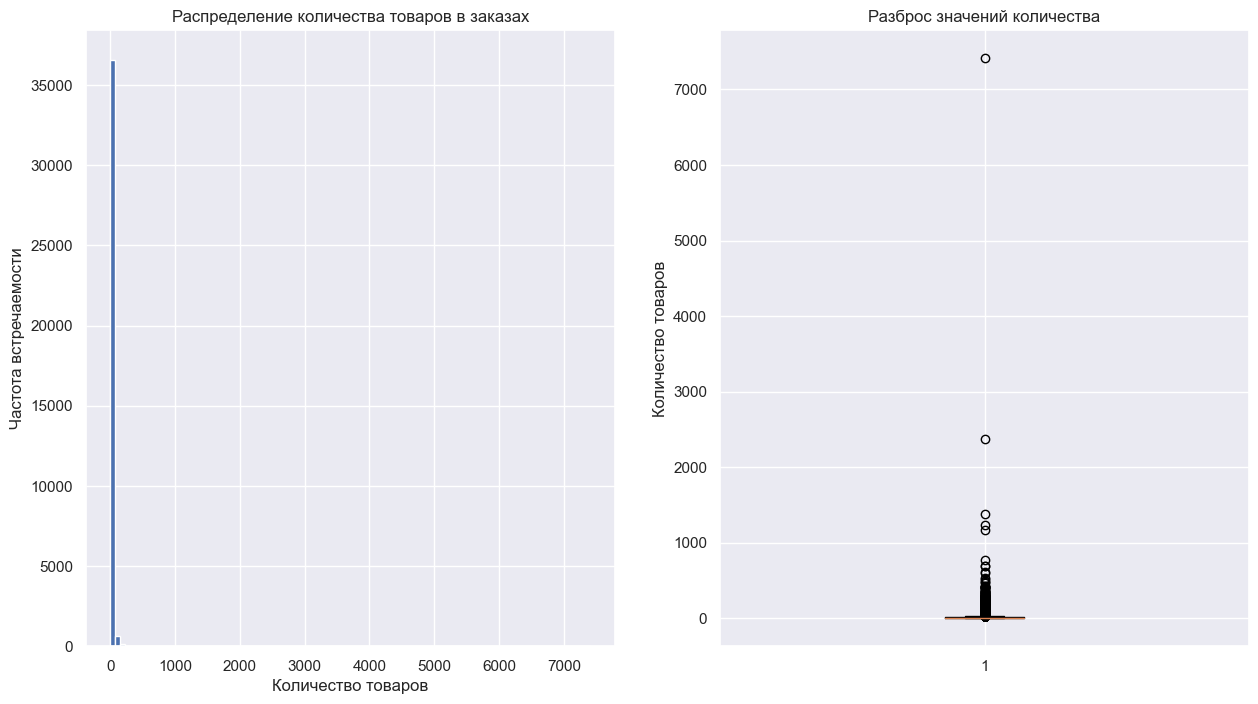

In [90]:
show_hist_boxplot(data.quantity, bins=100,
                  hist_title='Распределение количества товаров в заказах',
                  hist_xlabel='Количество товаров', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество товаров')

Как мы и предполагали, в данных присутствуют выбросы. Избавимся от них:

In [92]:
data = data.drop(data[data.quantity > 30].index)

Визуализируем обновленные данные:

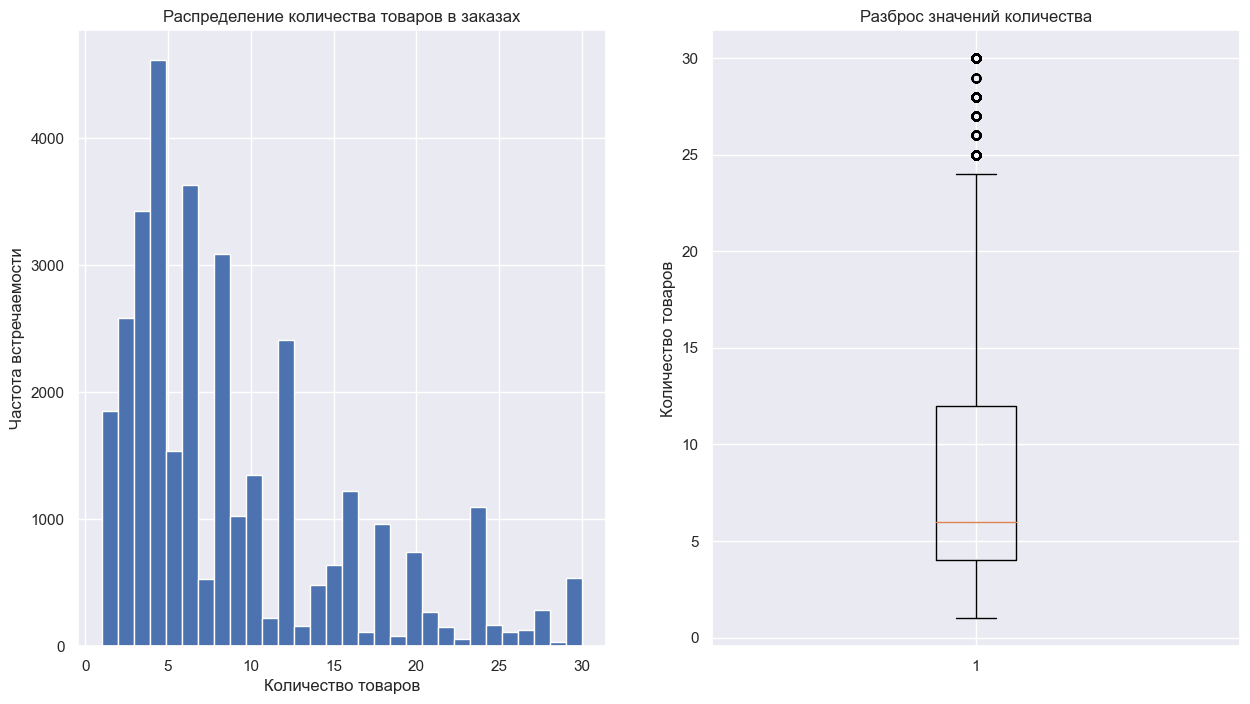

In [94]:
show_hist_boxplot(data.quantity, bins=30,
                  hist_title='Распределение количества товаров в заказах',
                  hist_xlabel='Количество товаров', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество товаров')

Как видно, чаще всего корзина состоит из 4 товаров. Менее часто - из трех и двух. Корзины из одного и шести товаров встречаются с однаковой частотой.

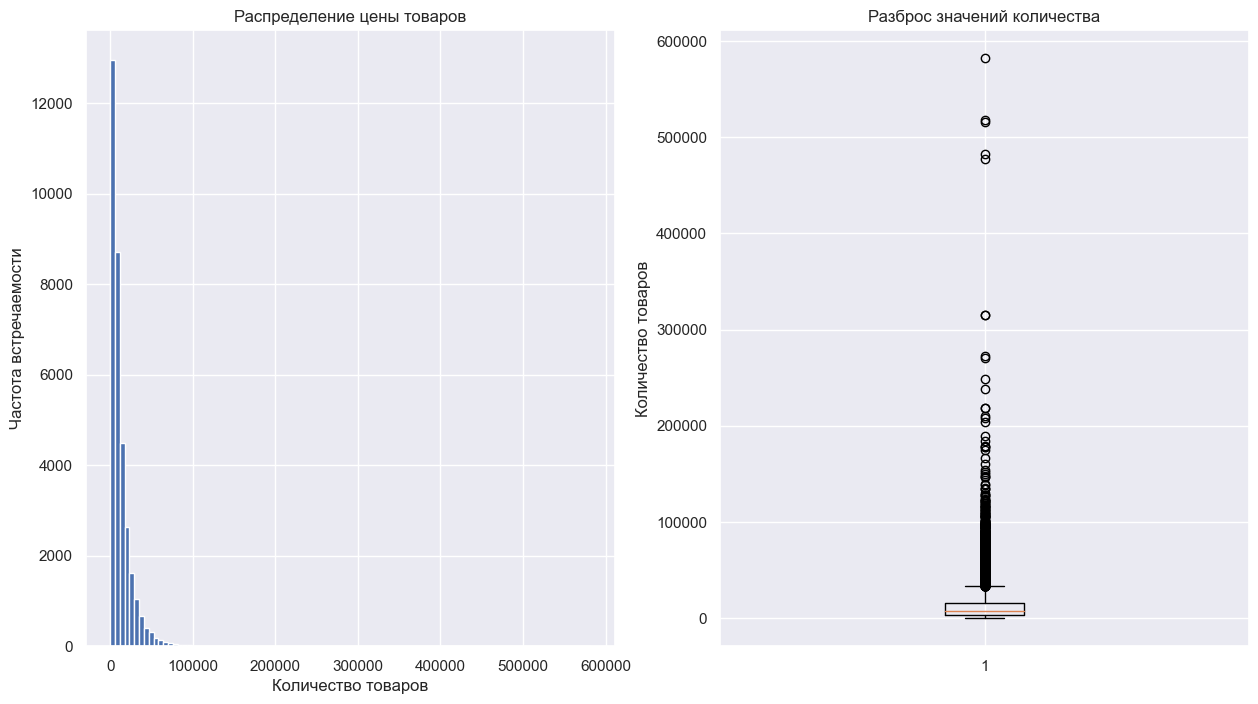

In [96]:
show_hist_boxplot(data.price, bins=100,
                  hist_title='Распределение цены товаров',
                  hist_xlabel='Количество товаров', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество товаров')

Избавимся от выбросов в price:

In [98]:
data = data.drop(data[data.price > 80000].index)

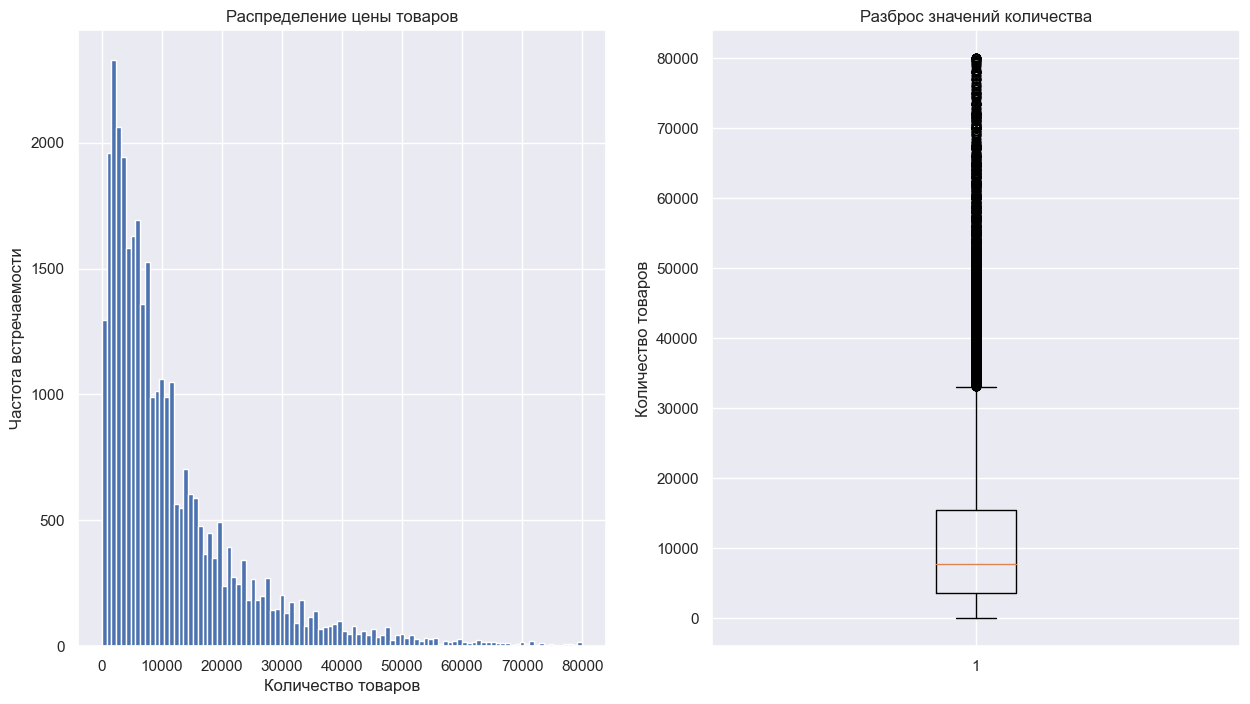

In [99]:
show_hist_boxplot(data.price, bins=100,
                  hist_title='Распределение цены товаров',
                  hist_xlabel='Количество товаров', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество товаров')

На графике распределения цены мы ожидаемо видим снижение количества купленных товаров с ростом их стоимости. Самая частая стоимость всей корзины - порядка 4-5 тысяч.

In [101]:
events = data.groupby('event')['price'].count()
events

event
click        1917
open          386
purchase    31045
send            4
Name: price, dtype: int64

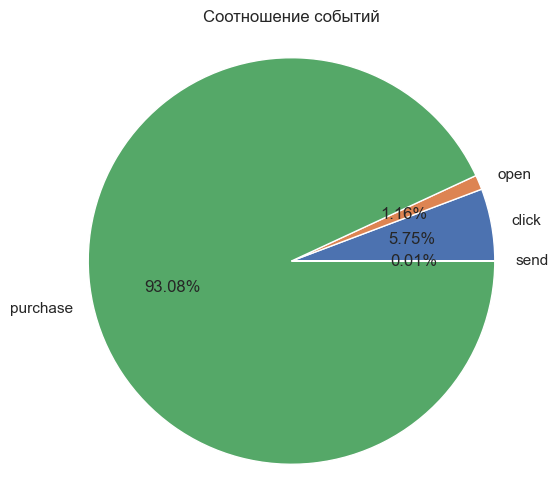

In [102]:
events.plot(title='Соотношение событий', kind='pie', autopct=lambda x: f'{x:.2f}%', ylabel='', radius=1.1, grid=True, figsize=(15, 6));

Как видно, большинство (93%) событий имеют тип purchase, на втором месте - click (почти 6%). Доля остальных событий слишком мала в процентном отношении

In [104]:
channels = data.groupby('channel')['price'].count()
channels

channel
email          21751
mobile_push    11601
Name: price, dtype: int64

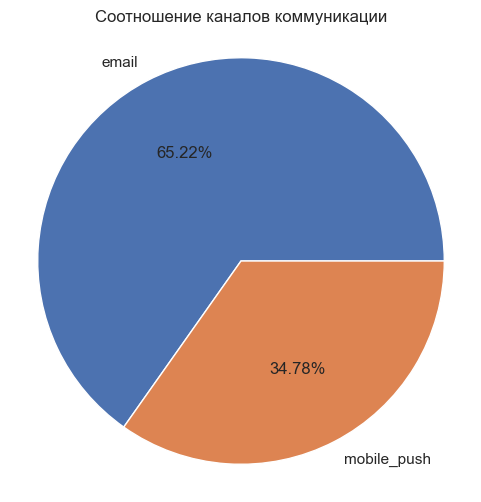

In [105]:
channels.plot(title='Соотношение каналов коммуникации', kind='pie', autopct=lambda x: f'{x:.2f}%', ylabel='', radius=1.1, grid=True, figsize=(15, 6));

65% сообщений рассылаются по электронной почте, 35% - в пушах мобильных приложений

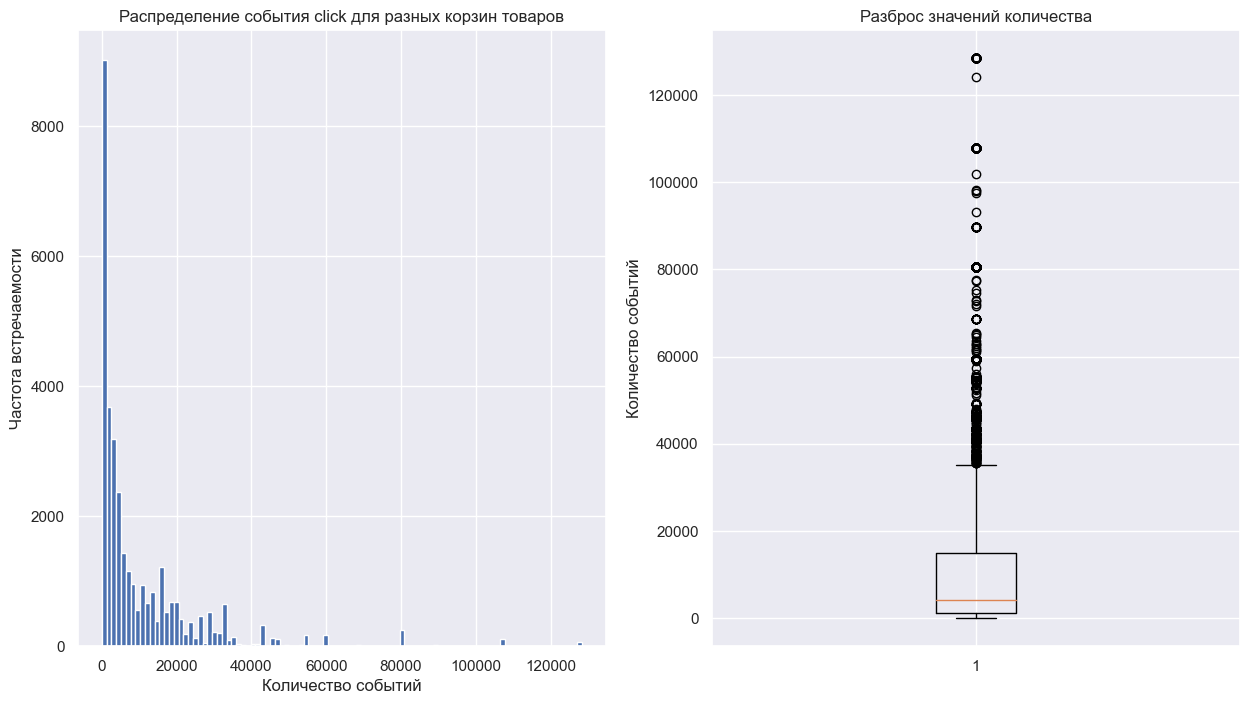

In [107]:
show_hist_boxplot(data.count_click, bins=100,
                  hist_title='Распределение события click для разных корзин товаров',
                  hist_xlabel='Количество событий', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество событий')

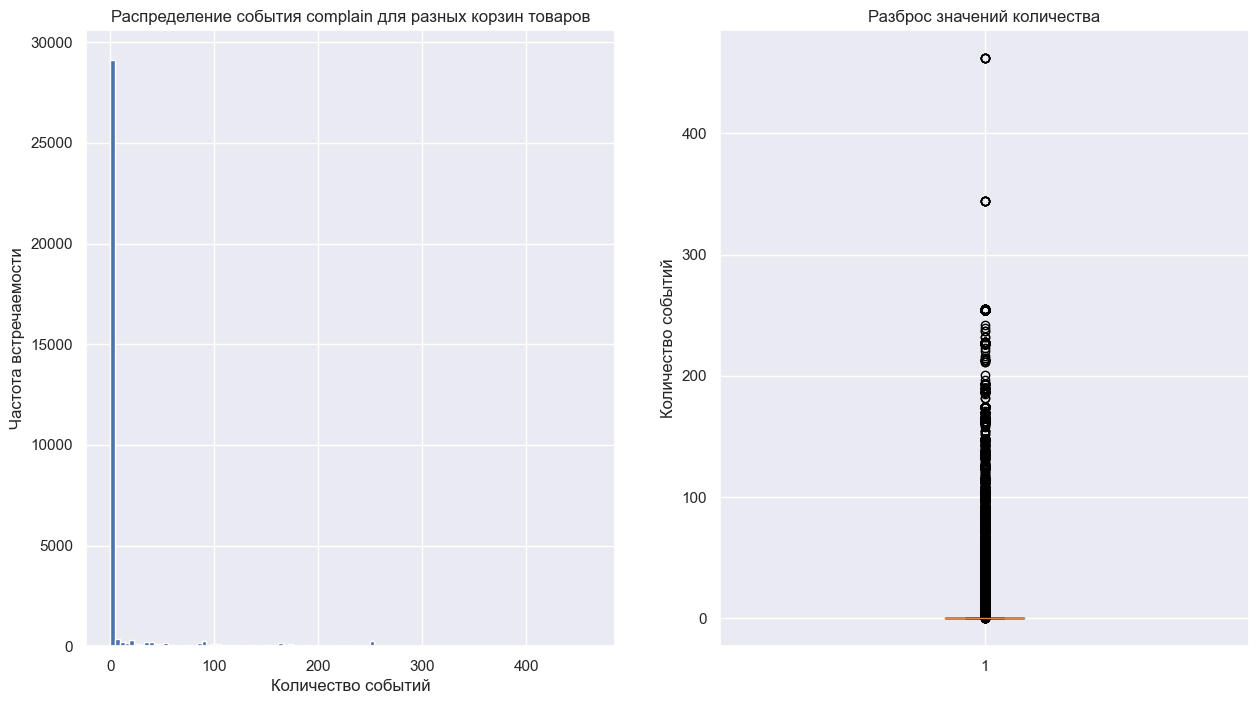

In [108]:
show_hist_boxplot(data.count_complain, bins=100,
                  hist_title='Распределение события complain для разных корзин товаров',
                  hist_xlabel='Количество событий', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество событий')

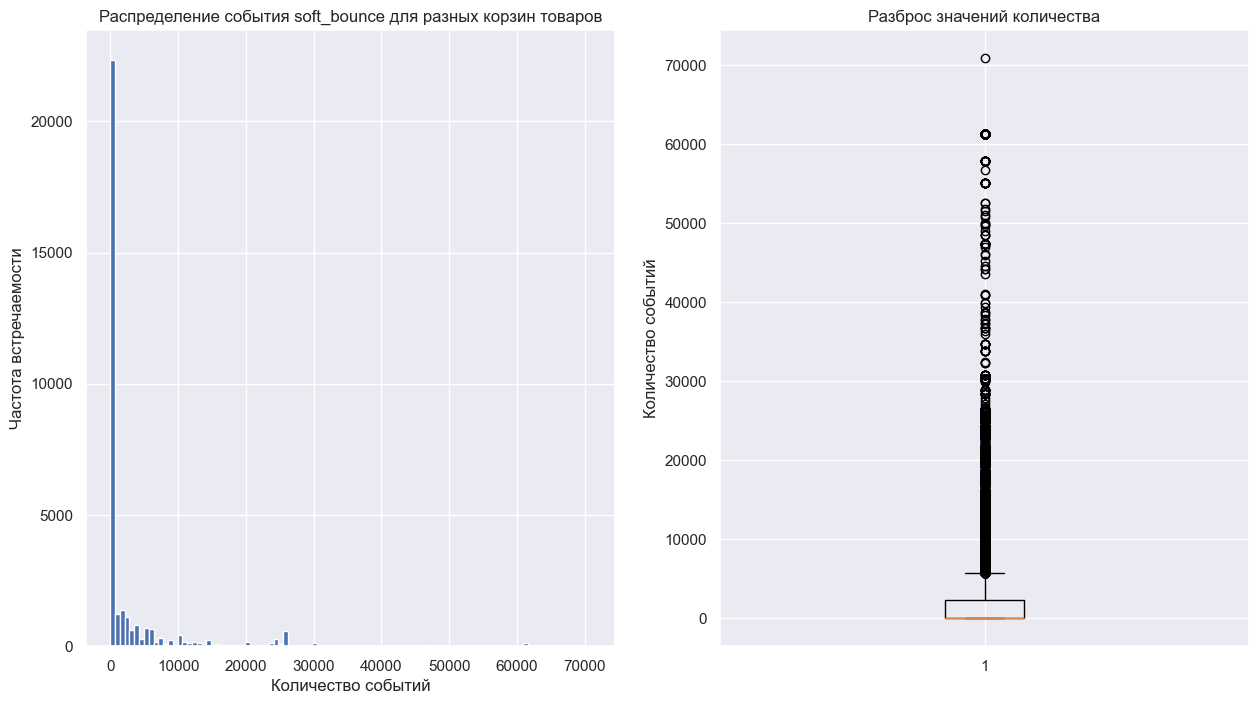

In [109]:
show_hist_boxplot(data.count_soft_bounce, bins=100,
                  hist_title='Распределение события soft_bounce для разных корзин товаров',
                  hist_xlabel='Количество событий', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество событий')

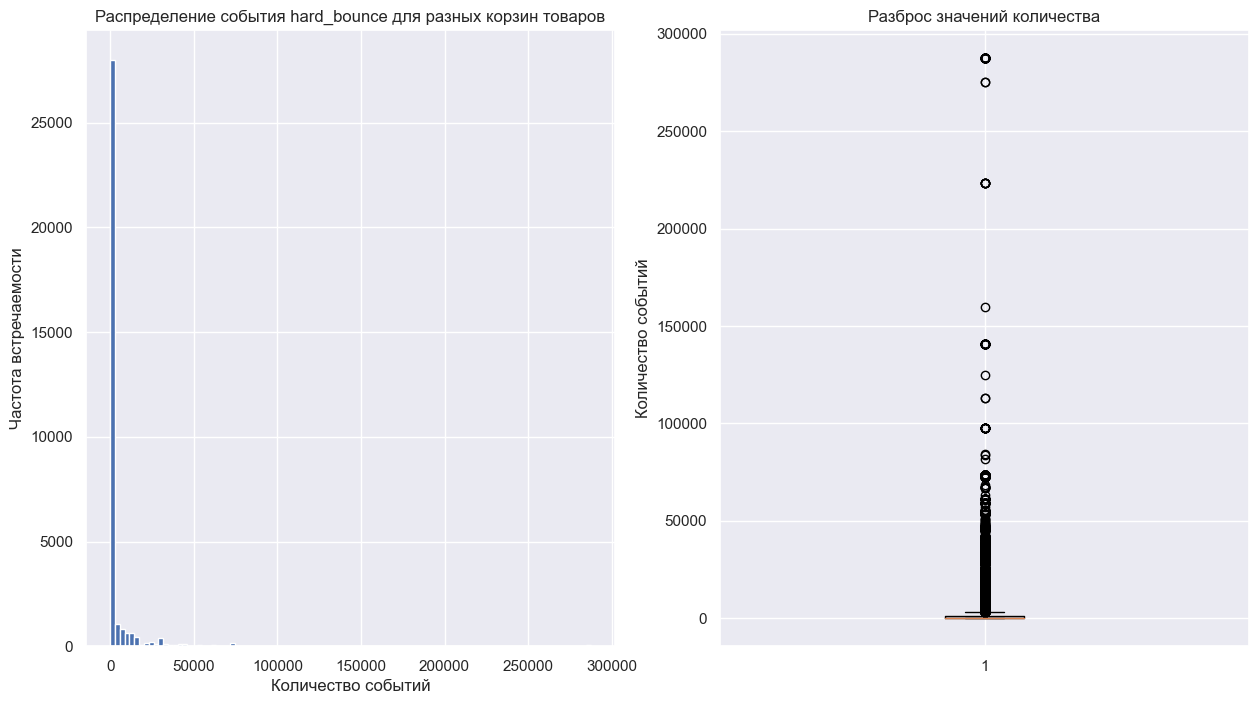

In [110]:
show_hist_boxplot(data.count_hard_bounce, bins=100,
                  hist_title='Распределение события hard_bounce для разных корзин товаров',
                  hist_xlabel='Количество событий', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество событий')

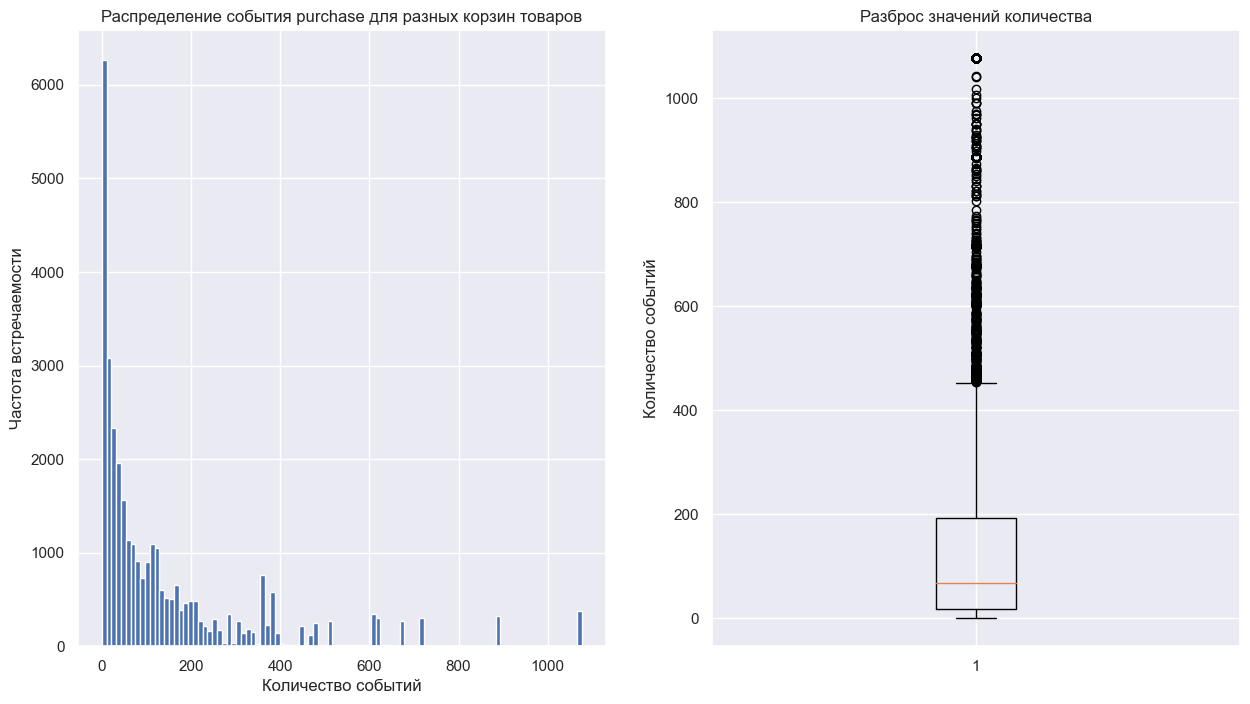

In [111]:
show_hist_boxplot(data.count_purchase, bins=100,
                  hist_title='Распределение события purchase для разных корзин товаров',
                  hist_xlabel='Количество событий', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество событий')

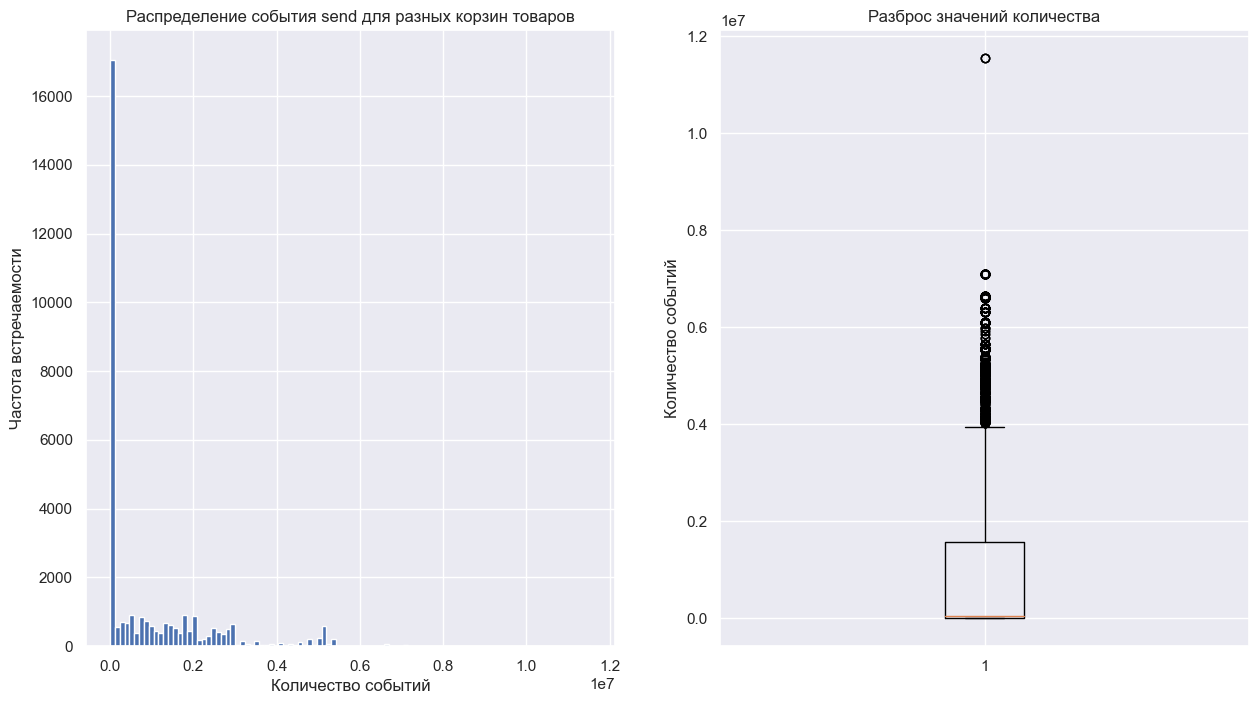

In [112]:
show_hist_boxplot(data.count_send, bins=100,
                  hist_title='Распределение события send для разных корзин товаров',
                  hist_xlabel='Количество событий', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество событий')

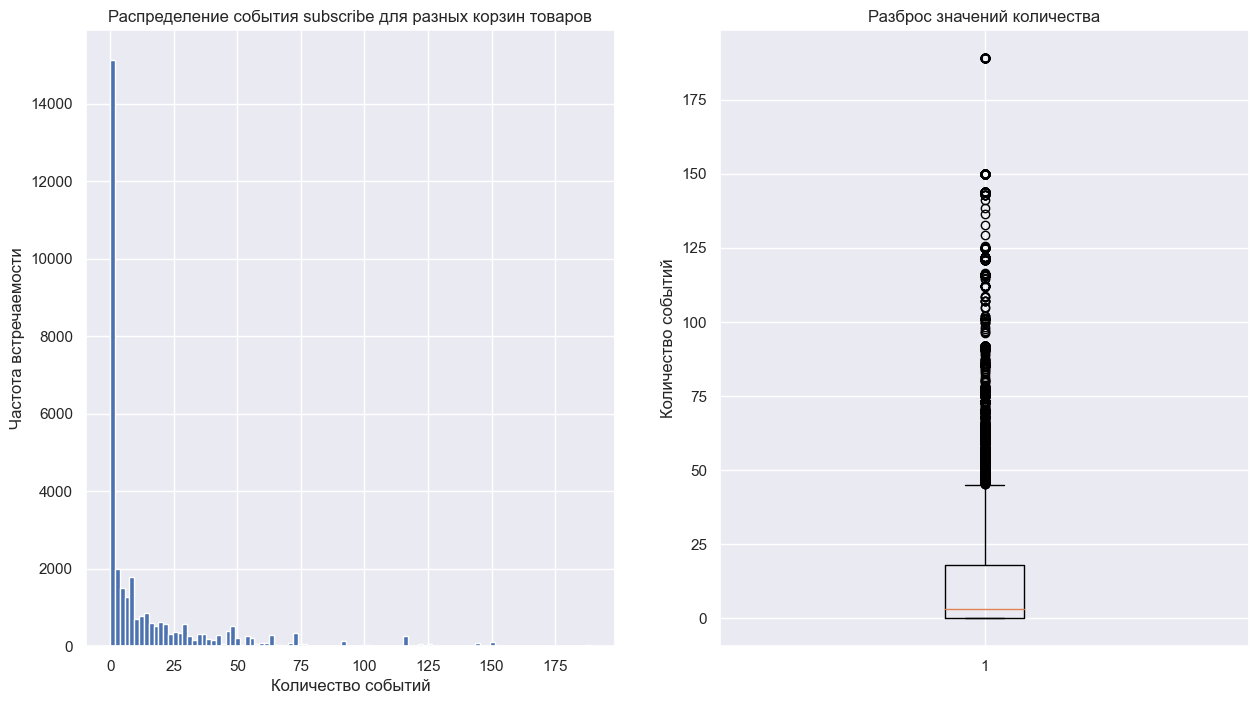

In [113]:
show_hist_boxplot(data.count_subscribe, bins=100,
                  hist_title='Распределение события subscribe для разных корзин товаров',
                  hist_xlabel='Количество событий', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество событий')

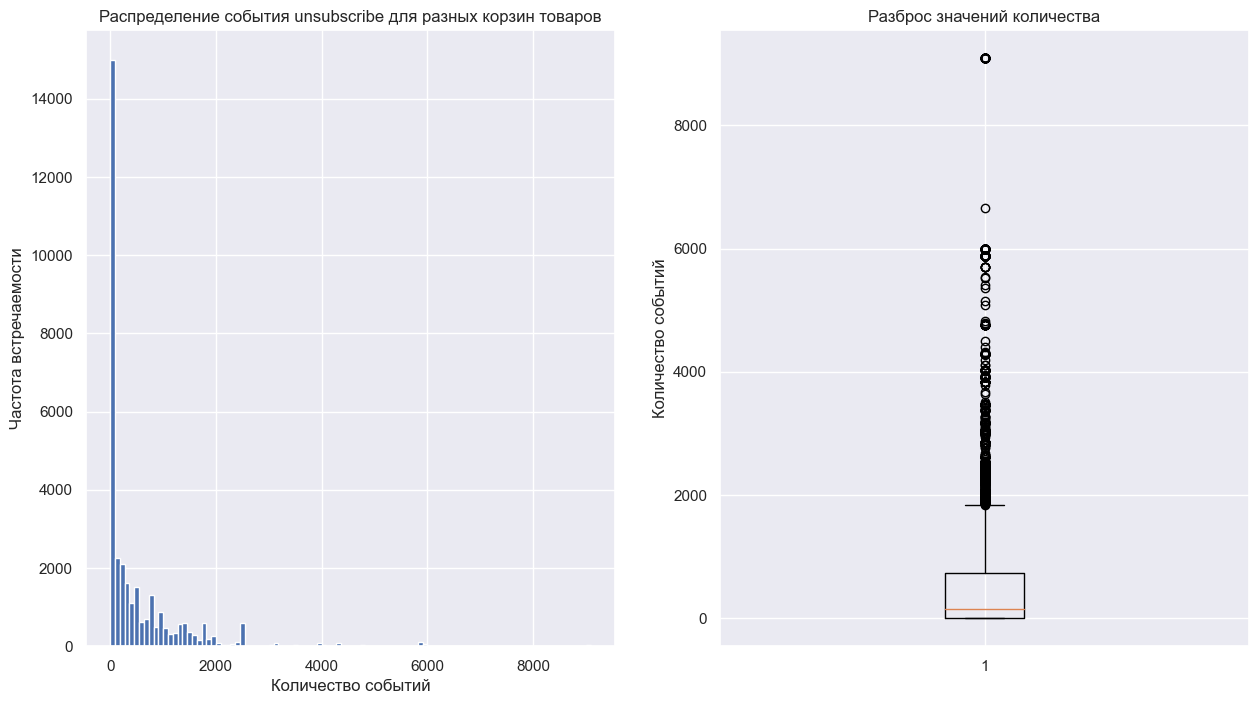

In [114]:
show_hist_boxplot(data.count_unsubscribe, bins=100,
                  hist_title='Распределение события unsubscribe для разных корзин товаров',
                  hist_xlabel='Количество событий', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества', bp_ylabel='Количество событий')

Графики с показателями счетчиков по разным событиям дают нам немного информации: большинство рассылок не приводит к каким-либо действиям со стороны пользователей

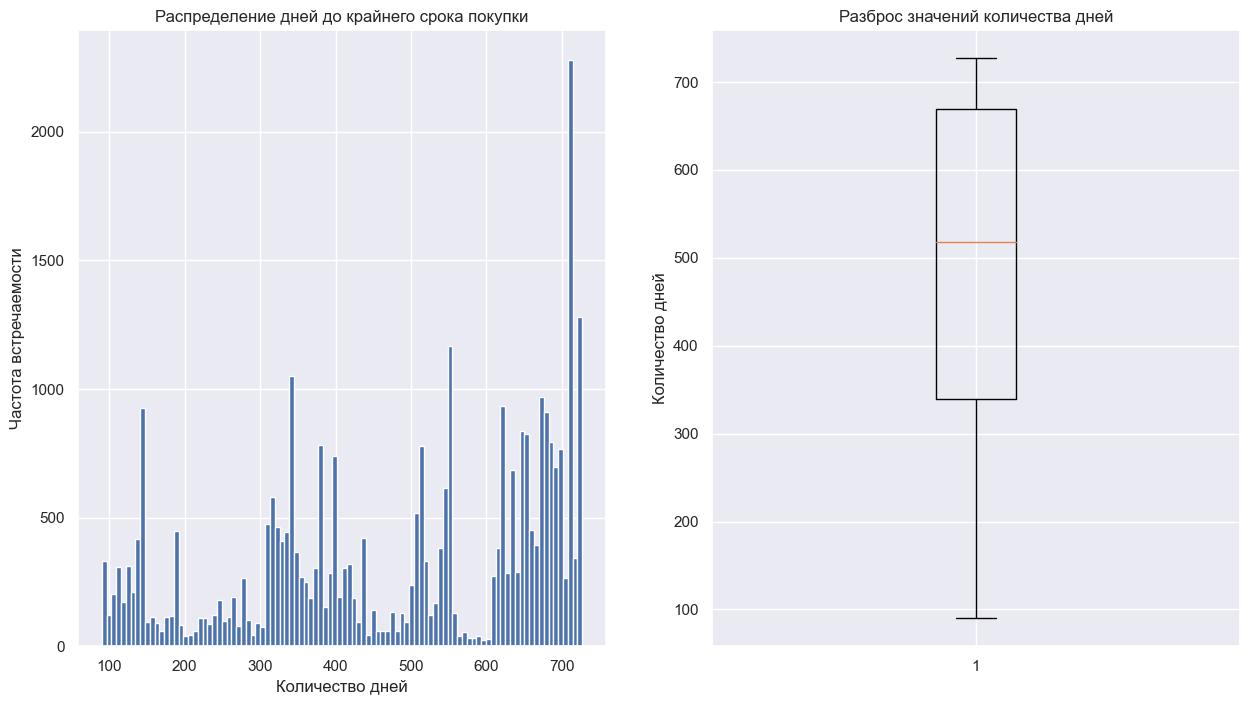

In [116]:
show_hist_boxplot(data.days_until_purchase, bins=100,
                  hist_title='Распределение дней до крайнего срока покупки',
                  hist_xlabel='Количество дней', hist_ylabel='Частота встречаемости',
                  bp_title='Разброс значений количества дней', bp_ylabel='Количество дней')

На графике видно, что подавляющее число сообщений были направлены достаточно давно - более года назад

In [118]:
targets = data.groupby('target')['price'].count()
targets

target
0    32767
1      585
Name: price, dtype: int64

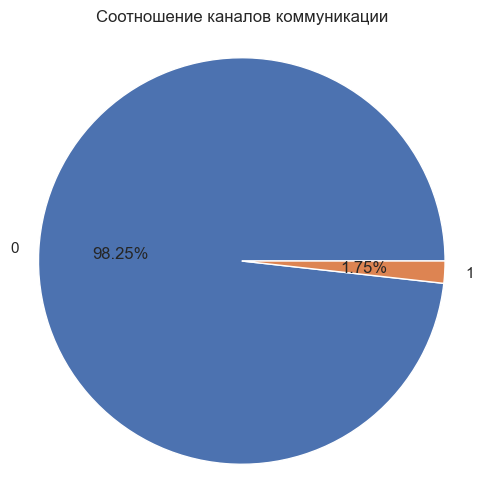

In [119]:
targets.plot(title='Соотношение каналов коммуникации', kind='pie', autopct=lambda x: f'{x:.2f}%', ylabel='', radius=1.1, grid=True, figsize=(15, 6));

Соотношение классов целевого признака крайне неравномерно: в 98% случаев пользователь не совершает покупку. Совершает он ее лишь в 585 случаев из 33.000

Чтобы увеличить эффективность обучения моделей на имеющихся данных в дальнейшем применим метод оверсэмплинга, чтобы сравнять число наблюдений в каждом из классов

### Вывод по разделу

На этапе визуализации данных мы наглядно увидели, как распределяются и соотносятся между собой признаки в выборке. Так, мы узнали, что для целевого признака необходимо применить метод оверсэмплинга для повышения эффективности обучения

Поскольку оверсэмплинг может работать только с числовыми признаками, откажемся от столбцов event и channel:

In [125]:
data = data.drop(['event', 'channel'], axis=1)

## Корреляционный анализ

interval columns not set, guessing: ['quantity', 'price', 'count_click', 'count_complain', 'count_soft_bounce', 'count_hard_bounce', 'count_purchase', 'count_send', 'count_subscribe', 'count_unsubscribe', 'days_until_purchase', 'target']


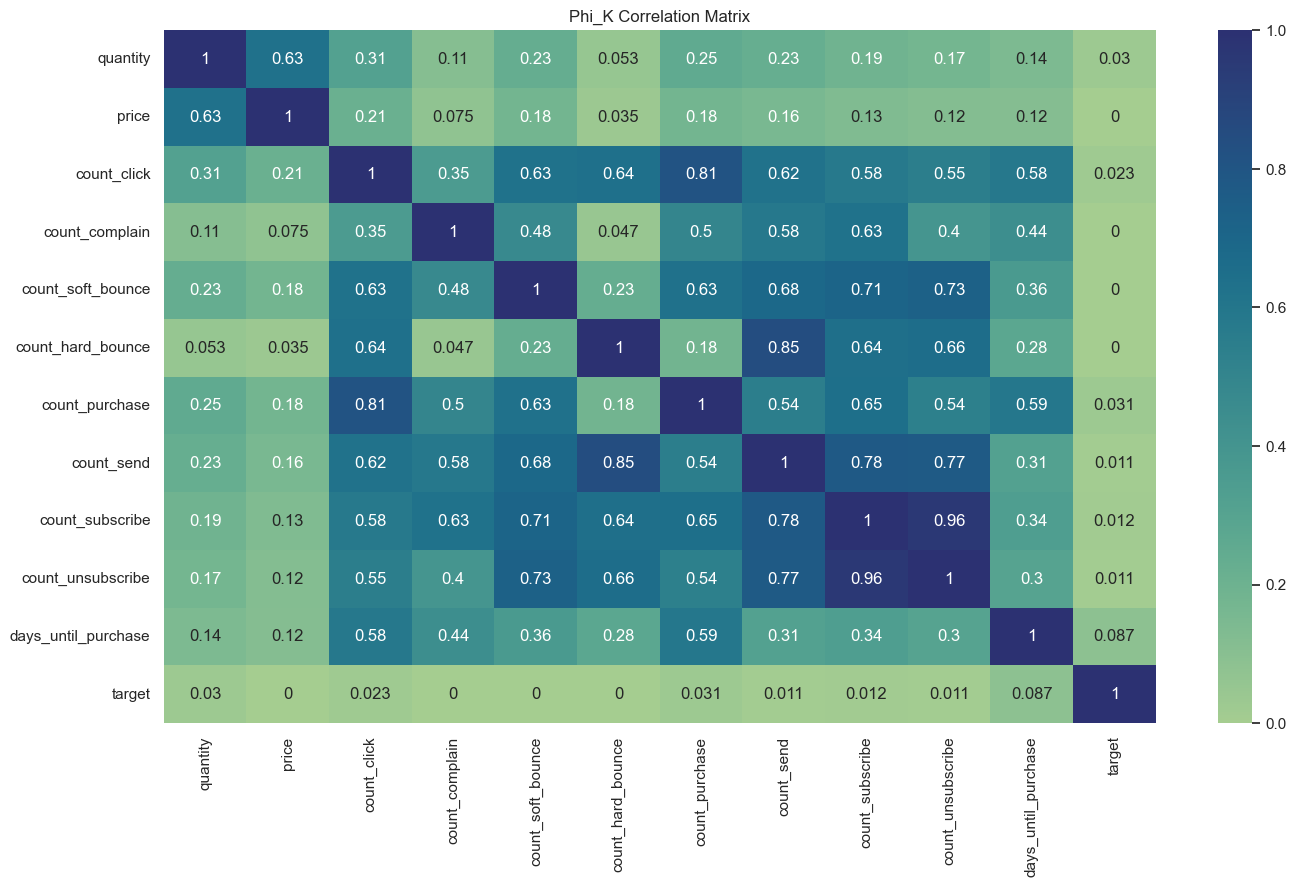

In [127]:
corr_matrix = data.phik_matrix()

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='crest')
plt.title('Phi_K Correlation Matrix')
plt.show()

### Вывод по разделу

<div>
Целевой признак имеет почти нулевую корреляцию с входными признаками. Возможно, ситуация такова потому что слишком мало наблюдений, в которых покупка была совершена, а возможно, данные действительно не связаны между собой
<br>Кроме того, мы видим высокую линейную зависимость между count_subscribe и count_unsubscribe - в данных возможно наличие мультиколлинеарности
</div>

## Мультиколлинеарность

Исходя из результатов, полученных в матрице корреляции, дополнительно проверим данные на мультиколлинеарность:

In [132]:
needed_col_names = ['quantity', 'price', 'count_click', 'count_complain', 'count_soft_bounce',
                    'count_hard_bounce', 'count_purchase', 'count_send', 'count_subscribe',
                    'count_unsubscribe', 'days_until_purchase']
vif_data_src = data[needed_col_names]
vif_data_src['const'] = 1
vif_data_src.head()

,quantity,price,count_click,count_complain,count_soft_bounce,count_hard_bounce,count_purchase,count_send,count_subscribe,count_unsubscribe,days_until_purchase,const
1,28,64940,10139.0,0.0,14208.0,2902.0,62.0,4543310.0,38.0,1521.0,497,1
2,2,2098,6991.0,0.0,0.0,0.0,54.0,3.0,0.0,0.0,95,1
4,3,2997,4149.0,0.0,1.0,0.0,165.0,0.0,1.0,216.0,655,1
5,4,5996,18554.0,0.0,0.0,0.0,373.0,1315301.0,7.0,479.0,635,1
6,4,1196,16428.0,0.0,13388.0,1623.0,87.0,2616640.0,50.0,1331.0,658,1


In [133]:
vif_data = pd.DataFrame()
needed_col_names.append('const')
vif_data["feature"] = needed_col_names

vif_data

,feature
0,quantity
1,price
2,count_click
3,count_complain
4,count_soft_bounce
5,count_hard_bounce
6,count_purchase
7,count_send
8,count_subscribe
9,count_unsubscribe


In [134]:
vif_data["VIF"] = [f'{variance_inflation_factor(vif_data_src, i):.5f}' for i in range(len(needed_col_names))]
vif_data

,feature,VIF
0,quantity,1.60892
1,price,1.60615
2,count_click,2.00080
3,count_complain,1.58852
4,count_soft_bounce,2.87642
5,count_hard_bounce,1.51357
6,count_purchase,1.87909
7,count_send,3.43292
8,count_subscribe,16.58458
9,count_unsubscribe,14.23890


Мультиколлинеарность обнаружена: признаки count_subscribe и count_unsubscribe имеют высокую степень коллинеарности, а значит мы можем избавиться от одного из признаков без потери точности модели. Избавимся от count_unsubscribe и снова проверим данные:

In [136]:
needed_col_names = ['quantity', 'price', 'count_click', 'count_complain', 'count_soft_bounce',
                    'count_hard_bounce', 'count_purchase', 'count_send', 'count_subscribe',
                    'days_until_purchase']
vif_data_src = data[needed_col_names]
vif_data_src['const'] = 1

vif_data = pd.DataFrame()
needed_col_names.append('const')
vif_data["feature"] = needed_col_names

vif_data["VIF"] = [f'{variance_inflation_factor(vif_data_src, i):.5f}' for i in range(len(needed_col_names))]
vif_data

,feature,VIF
0,quantity,1.60854
1,price,1.60602
2,count_click,1.99776
3,count_complain,1.29908
4,count_soft_bounce,2.86424
5,count_hard_bounce,1.42381
6,count_purchase,1.87787
7,count_send,3.41302
8,count_subscribe,2.41755
9,days_until_purchase,1.24148


Мультиколлинеарность исчезла, а значит мы все сделали правильно. Удалим признак из датасета:

In [138]:
data = data.drop('count_unsubscribe', axis=1)
data.head()

,quantity,price,count_click,count_complain,count_soft_bounce,count_hard_bounce,count_purchase,count_send,count_subscribe,days_until_purchase,target
1,28,64940,10139.0,0.0,14208.0,2902.0,62.0,4543310.0,38.0,497,1
2,2,2098,6991.0,0.0,0.0,0.0,54.0,3.0,0.0,95,0
4,3,2997,4149.0,0.0,1.0,0.0,165.0,0.0,1.0,655,0
5,4,5996,18554.0,0.0,0.0,0.0,373.0,1315301.0,7.0,635,0
6,4,1196,16428.0,0.0,13388.0,1623.0,87.0,2616640.0,50.0,658,0


### Вывод по разделу

В ходе этапа мы проверили данные на мультиколлинеарность и обнаружили ее. Также избавились от столбца, который был коллинеарен с другим признаком. Осуществить данную проверку было важно, поскольку на этапе проверки данных на корреляцию мы обнаружили очень высокий коээфициент корреляции, и была вероятность, что данные коллинеарны. Кроме того, мультиколлинеарность в данных не позволяет в должной мере определить, какие признаки важны для модели, а значит предоставить бизнесу некачественное исследование и результаты.

## Обучение модели

In [142]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [143]:
num_columns = ['quantity', 'price', 'count_click', 'count_complain', 'count_soft_bounce',
               'count_hard_bounce', 'count_purchase', 'count_send', 'count_subscribe',
               'days_until_purchase']

In [144]:
X = data.drop('target', axis=1)
y = data['target']

Воспользуемся техникой оверсэмплинга для выравнивания соотношения классов в целевом признаке:

In [146]:
sampler = ADASYN(random_state=RANDOM_STATE)

In [147]:
X_resample, y_resample = sampler.fit_resample(X, y)

Теперь же получим тренировочные и тестовые выборки:

In [149]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resample,
    y_resample,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y_resample)

In [150]:
num_pipe = Pipeline(
    [('simpleImputer_before_num', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('num', MinMaxScaler()),
     ('simpleImputer_after_num', SimpleImputer(missing_values=np.nan, strategy='median'))
    ]
)

In [151]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [152]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Зададим гиперпараметры модели:

In [154]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__C': range(1, 10),
        'models__degree': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Инициализируем поисковую сетку:

In [156]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [157]:
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['quantity', 'price',
                                                   'count_click',
                                                   'count_complain',
                                                   'count_soft_bounce',
                                                   'count_hard_bounce',
                                                   'count_purchase',
                                                   'count_send',
                                                   'count_subscribe',
                                                   'days_until_purchase'])])),
                ('models', KNeighborsClassifier(n_neighbors=2))])


In [158]:
print (f'Метрика лучшей модели на кросс-валидации: {randomized_search.best_score_:.4f}')

Метрика лучшей модели на кросс-валидации: 0.9218


In [159]:
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba):.4f}')

Метрика ROC-AUC на тестовой выборке: 0.9308


Отобразим полученные результаты на графике:

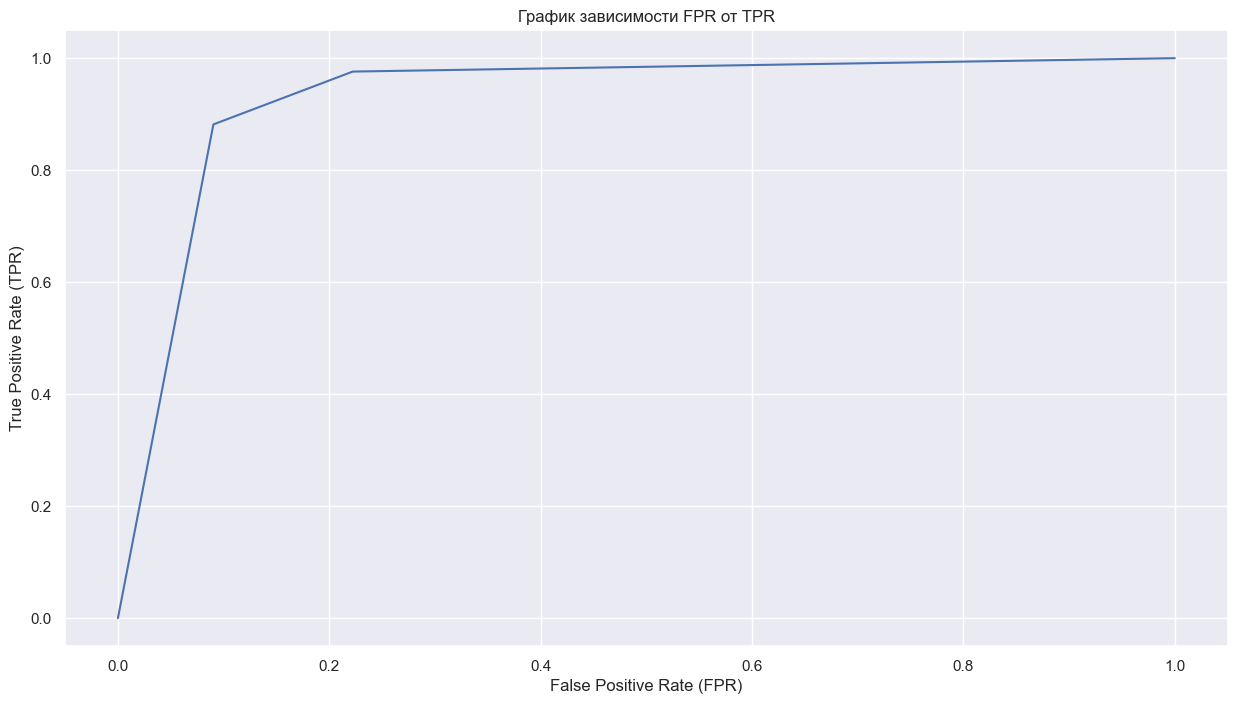

In [161]:
fpr, tpr, threshold = roc_curve(y_test, y_test_proba)

plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

Итак, на тренировочных данных модель показала результат в ROC-AUC=0.9218, на тестовых данных - 0.9308. Весьма неплохой результат. Напомним, максимальное значение показателя - единица.

Также посмотрим на топ-10 лучших результатов среди всех моделей:

In [164]:
needed_columns = ['rank_test_score', 'mean_test_score', 'param_models', 'params']
pd.DataFrame(randomized_search.cv_results_)[needed_columns].sort_values(by='mean_test_score', ascending=False)

,rank_test_score,mean_test_score,param_models,params
6,1,0.921773,KNeighborsClassifier(n_neighbors=2),"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,2,0.834850,"SVC(probability=True, random_state=42)","{'preprocessor__num': StandardScaler(), 'model..."
0,3,0.830689,"SVC(probability=True, random_state=42)","{'preprocessor__num': StandardScaler(), 'model..."
3,4,0.792806,"SVC(probability=True, random_state=42)","{'preprocessor__num': MinMaxScaler(), 'models_..."
8,5,0.786692,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__..."
4,6,0.784868,"SVC(probability=True, random_state=42)","{'preprocessor__num': MinMaxScaler(), 'models_..."
1,7,0.756229,"SVC(probability=True, random_state=42)","{'preprocessor__num': MinMaxScaler(), 'models_..."
7,8,0.636982,"LogisticRegression(penalty='l1', random_state=...","{'preprocessor__num': StandardScaler(), 'model..."
9,9,0.636979,"LogisticRegression(penalty='l1', random_state=...","{'preprocessor__num': MinMaxScaler(), 'models_..."
2,10,0.563893,"SVC(probability=True, random_state=42)","{'preprocessor__num': 'passthrough', 'models__..."


Так, хорошие результаты показала модель опорных векторов, заняв 2-4 места. Третьей моделью, показавшей лучшие результаты, стала DecisionTreeClassifier, занявшая 5 место в рейтинге результатов.

### Вывод по разделу

В ходе данного этапа нами были обучены 4 модели, каждая из которых с набором собственных гиперпараметров. Лучшей моделью стала KNeighborsClassifier, показавшая метрику ROC-AUC=0.9308 на тестовых данных

## Анализ важности признаков

Дополнительно проведем исследование важности признаков для модели

### Permutation importance

In [171]:
preproc_num = randomized_search.best_estimator_['preprocessor'].transformers[0][1]
X_train_encoded = preproc_num.fit_transform(X_train[num_columns])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=num_columns, index=X_train.index)
X_test_encoded = preproc_num.transform(X_test[num_columns])
X_test_encoded = pd.DataFrame(X_test_encoded, columns=num_columns, index=X_test.index)

In [172]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X_train, y_train)

SelectKBest()

In [173]:
features_names = X_train.columns[selector.get_support(indices=True)]
X_train_new = X_train[list(features_names)]
X_test_new = X_test[list(features_names)]

In [174]:
def roc_auc_scoring(model, X, y):
    y_pred = model.predict(X)
    score = roc_auc_score(y, y_pred)
    return score

In [175]:
# обучаем лучшую модель 
best_model = randomized_search.best_estimator_['models']
best_model.fit(X_train_new, y_train)

KNeighborsClassifier(n_neighbors=2)

In [176]:
result = permutation_importance(best_model, X_test_new, y_test, scoring=roc_auc_scoring)

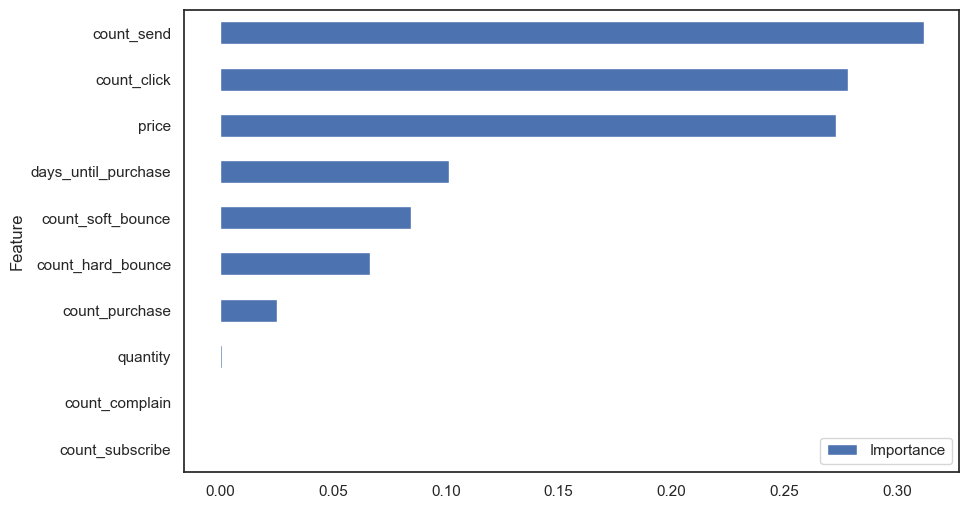

In [177]:
feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

Итак, мы отчетливо видим признаки-лидеров с точки зрения модели: наиболее важными оказались count_send, count_click и price

### SHAP-значения

In [180]:
X_test_new.iloc[:10, :]

,quantity,price,count_click,count_complain,count_soft_bounce,count_hard_bounce,count_purchase,count_send,count_subscribe,days_until_purchase
59285,3,4177,403.680250,0.0,0.000000,0.000000,10.603397,0.000000e+00,0.0,616
23387,10,5990,43355.000000,0.0,25591.000000,2750.000000,887.000000,5.110620e+06,73.0,714
35865,11,6764,3846.233283,0.0,0.000000,6540.480134,71.773129,1.313253e+06,0.0,548
6951,10,25990,10327.500000,0.0,3805.500000,452.000000,237.500000,6.576505e+05,5.5,635
60495,4,1116,315.255276,0.0,1.246965,0.000000,1.623482,0.000000e+00,0.0,121
10940,2,2989,788.000000,9.0,2.000000,0.000000,44.000000,0.000000e+00,6.0,439
58411,9,10186,14099.403118,0.0,339.699865,6914.666656,53.432143,8.298503e+05,0.0,271
5153,2,3218,1505.000000,33.0,4.000000,0.000000,53.000000,0.000000e+00,9.0,374
53024,11,6923,1417.363045,0.0,653.214604,2915.376251,3.914024,8.477144e+05,0.0,136
60554,2,1068,1002.992639,0.0,0.000000,0.000000,122.716977,0.000000e+00,0.0,523


In [181]:
explainer = shap.KernelExplainer(best_model.predict_proba, X_test_new.iloc[:10, :])
shap_values = explainer(X_test_new)

  0%|          | 0/16418 [00:00<?, ?it/s]

Разберем важность признаков на конкретном наблюдении:

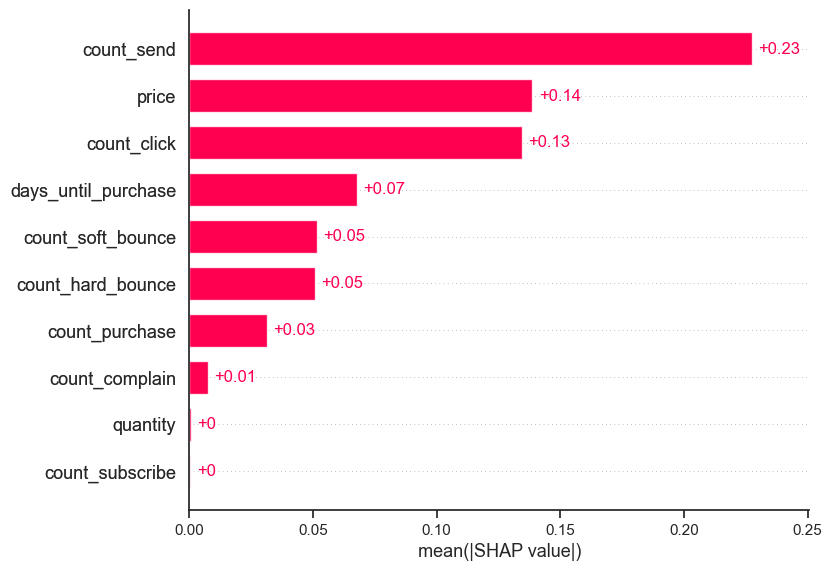

In [183]:
shap.plots.bar(shap_values[:, :, 1], max_display=10)

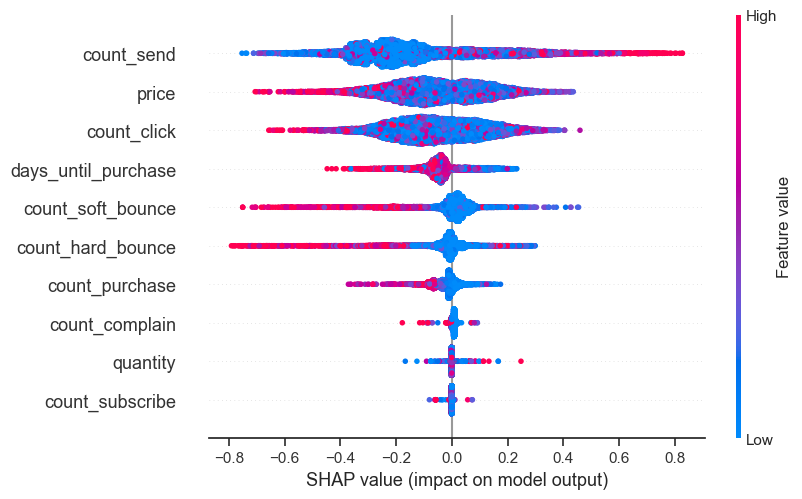

In [184]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=10)

<div>
Мы видим, что с ростом признака count_send растет вероятность того, что покупка будет совершена
<br>Рост price, напротив, уменьшает эту вероятность
<br>Чем меньше значение count_click, тем выше вероятность покупки
<br>days_until_purchase, как и price, увеличивает шанс того, что покупка будет сделана, при его значение невелико
<br>Число count_soft_bounce и count_hard_bounce (мягкие и жесткие отказы), что объяснимо, имеют обратную корреляцию с целевым признаком
</div>

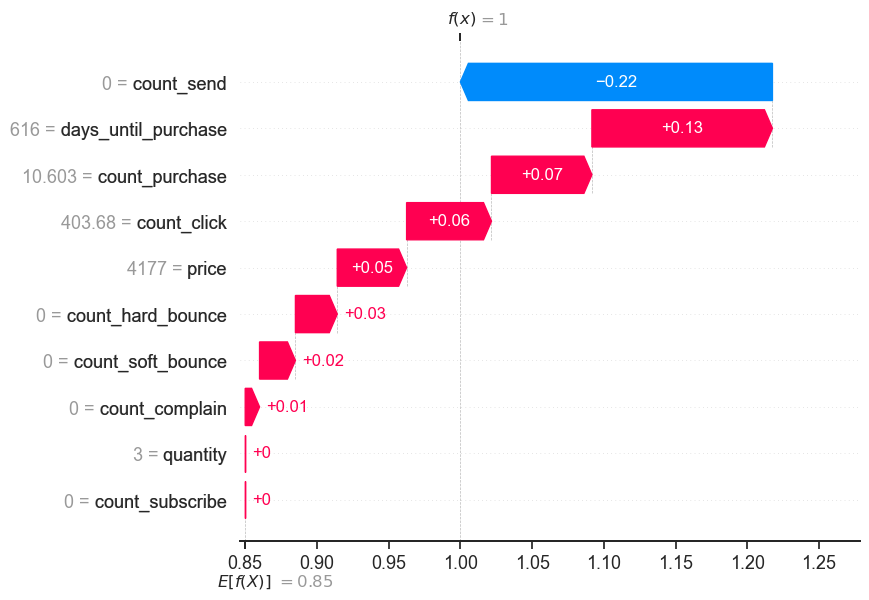

In [186]:
shap.plots.waterfall(shap_values[:, :, 1][0])

На графике мы видим, как для первого наблюдения происходит оценка вероятности покупки: count_send уменьшает вероятность такого исхода, тогда как остальные параметры наблюдения способствуют росту

### Вывод по разделу

В ходе этапа анализа важности признаков для модели мы выделили 3 признака, расценивающеся моделью как вносящие набольший вклад в определение вероятности покупки: ими стали count_send, count_click и price. Кроме того, мы детально разобрали веса признаков на примере 1-го наблюдения.

### Итоговый вывод

Целью данного исследования полагалась разработка модели машинного обучения, способной предсказать вероятность совершения покупки пользователем в течение следующих 90 дней - цель выполнена, такой моделью стала KNeighborsClassifier, показавшая метрику ROC-AUC=0.9308 при максимальном значении метрики в единицу.

В ходе данной работы мы изучили и подготовили данные к работе с моделью: осуществили предобработку, добавили новые ценные признаки и, напротив, отказались от признаков, не представлявших ценность для обучения модели. Затем мы изучили распределения и соотношения признаков в датасете и избавились от обнаруженных выбросов в данных.

Кроме прочего, мы также изучили, как признаки коррелируют друг с другом и проверили данные на наличие мультиколлинеарности, и, обнаружив ее, исправили. Наконец, мы обучили несколько моделей, а затем выбрали среди них одну, показавшую лучшие результаты на метрике ROC-AUC. Затем мы проверили модель на тестовых данных и подтвердили, что осуществили корректный выбор.